In [1]:
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

# Altair Demo

We're using the same dataset as before, but Altair has one dirty little secret - all it does when you plot is generate a JSON file with all your data,
and mappings and embed that into the html of your notebook, using Vega-lite to render that JSON into pretty D3.

That means that for each plot you have, you're embedding a JSON copy of your data into the notebook - not good if your dataset is 300,000 rows like ours is.

Luckily, Altair has solutions - it can stream from a file or from a url and Altair has mechanisms for doing that automatically.

By setting the backend to `json`, I tell Altair to save my data to disk as a JSON and use a reference to that. There's also a [altair_data_server](https://github.com/altair-viz/altair_data_server) you can run to serve the data from. Or you can of course dump your DataFrame to JSON and reference that directly.

Either way, Altair is not for Big Data™

Back on track: We will be making four plots again:

- [Number of Offenses per Month](#Number-of-Offenses-per-Month)
- [Number of Shootings per Month](#Number-of-Shootings-per-Month)
- [Top 10 Offense Code Groups](#Top-10-Offense-Code-Groups)
- [Number of Offenses per Day of Week and Hour of Day](#Number-of-Offenses-per-Day-of-Week-and-Hour-of-Day)

For some reason the ggplot2 theme colors are different here than in matplotlib?

In [4]:
import altair as alt
from load_data import load_data
from config import RED

alt.themes.enable('ggplot2')

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Due to the performance issue, I'm going to be using data only from 2018, otherwise I can't show you cool interactive stuff and that would suck ;-)

In [6]:
df = load_data().query('YEAR == 2018')

df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,0,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,0,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,0,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,0,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,0,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [7]:
brush = alt.selection_interval(encodings=['x'], empty='all')

Since Altair is building up a JSON behind the scenes, it's easy to set up common bits and simply overwrite the properties as needed.
Here we setup a common base, defining the size and something new. 

Altair supports data transformations as part of its grammar, so we can actually pass it raw data and declare data transformations in the plotting definition. 

Here I setup our chart with height and width defitions, and a new column called `month` containing a yearmonth version of our datetime, which all my other graphs can use - just as if I had added it to my dataframe upfront. Remember to DRY your code!

In [9]:
data = alt.Chart(df).properties(
    height=300,
    width=600
).transform_timeunit(month="yearmonth(OCCURRED_ON_DATE)")

# Number of Offenses per Month

Now I can setup a base chart for my number of offenses graph by building on my data definition.

I add a column called num_offenses by asking Altair to make a new column called `num_offenses` which is a simple count grouped by our previously defined `month` column

In [11]:
offenses_base = (
    data
    .properties(title="Offenses per Month")
    .transform_aggregate(num_offenses='count()', groupby=["month"])
)

Building on the base we just defined, I specify my encodings. If we want to give more details about our encodings, we can use the corresponding altair classes to specify additional options. Altair has a notion of type of data - whether it's Nominal, Ordinal, Quantitative or Time and will use that information to draw its plots. Often it can infer from the Dataframe dtypes, but our calculcated columns have to be specified. 

Note that I don't specify what mark to use - I want to have both circles and lines based on the same encoding, so I can just define the stuff they have in common here

In [12]:
offenses_line = (offenses_base
                 .encode(
                     x=alt.X("month:T", axis=alt.Axis(title=None)),
                     y=alt.Y("num_offenses:Q",scale=alt.Scale(zero=False), axis=alt.Axis(title="Monthly Offenses")),
                     tooltip=[alt.Tooltip("month:T", title="Date"),
                              alt.Tooltip("count()", title="Number of Offenses")])
                )

Finally we also declare a mean line. Altair provides us with some shortcuts, so I can specify I want the mean of offenses directly - no calculated column needed.

In [13]:
offenses_mean = (
    offenses_base
    .mark_rule(strokeDash=[8, 3])
    .transform_filter(brush)
    .encode(
        y="mean(num_offenses):Q",
        size=alt.value(1.5),
        color=alt.value(RED)
    )
)

Finally we add it all together (literally!). The `+` means _draw these on top of each other_ much like plotting on the same axis in matplotlib.

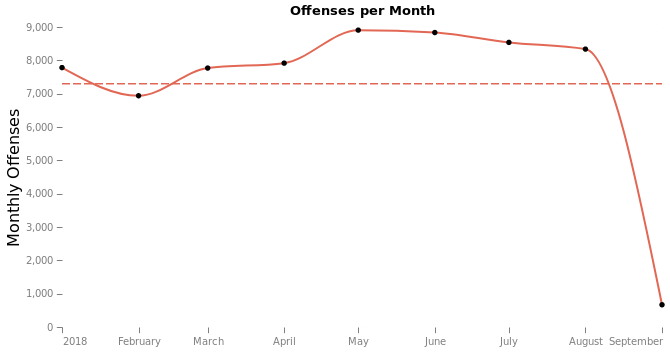

In [14]:

num_monthly_offenses = offenses_line.mark_line(interpolate='monotone', color=RED).add_selection(brush) + offenses_line.mark_circle(color="black") + offenses_mean
num_monthly_offenses

That's some pretty neat interactivity! And it cost us three lines of code total!

# Number of Shootings per Month

The number of shootings graph looks pretty much the same:

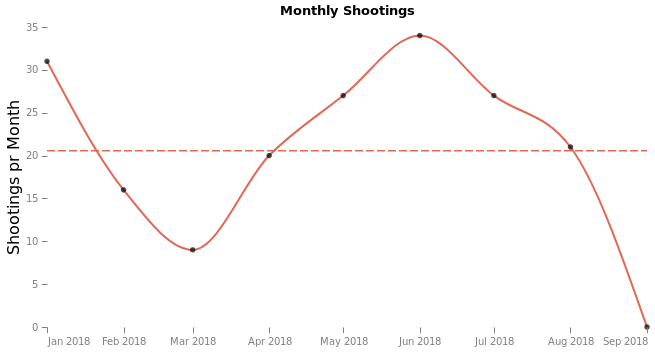

In [15]:
shooting_base = (data
        .properties(title="Monthly Shootings")
        .transform_aggregate(
            number_of_shootings="sum(SHOOTING)",
            groupby=["month"])
       )

shootings = (shooting_base
             .mark_line(interpolate='monotone', color=RED)
             .encode(x=alt.X("month:T", timeUnit="yearmonth", axis=alt.Axis(title=None)),
                     y=alt.Y("number_of_shootings:Q", axis=alt.Axis(title="Shootings pr Month")),
                     tooltip=[alt.Tooltip("number_of_shootings:Q", title="Number of Shootings"),
                              alt.Tooltip("yearmonth(month)", title="Date")])
             
            )

shootings_mean_line = shooting_base.encode(
    y="mean(number_of_shootings):Q",
    color=alt.value(RED),
    size=alt.value(1.5)
).mark_rule(strokeDash=[8, 3]).transform_filter(brush)


shootings_per_month =  shootings.add_selection(brush) + shootings.mark_circle(color="black") + shootings_mean_line
shootings_per_month

# Top 10 Offense Code Groups

Here Altair shows off some of it's data transformation capabilities. We aggregate by doing a count per OFFENSE_CODE_GROUP, use a transform_window to get a ranking of the sorted counts and then we filter out all the rows where rank < 10 

_Note: datum is a generic row accessor - imagine it as the `i` of an iterator_

It's easy to miss, but nowhere have I said I want a barh. By specifying that my y encoding is the OFFENSE_CODE_GROUP column, Altair figures out that a horizontal bar chart is the way to represent my encodings.

Also, how much easier was it to add text labels? I simply built on top of my existing graph, defining an additional encoding and mark, `+` them together and voila!

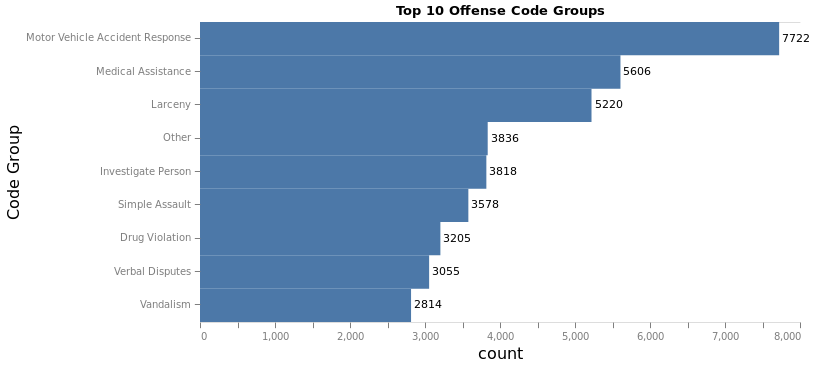

In [16]:
top10 = (data
         .properties(title="Top 10 Offense Code Groups")
         .transform_aggregate(
            count='count()',
            groupby=['OFFENSE_CODE_GROUP'])
         .transform_window(
             rank='rank(count)',
             sort=[alt.SortField('count', order='descending')])
         .transform_filter(alt.datum.rank < 10)
         .mark_bar()
         .encode(
             y=alt.Y('OFFENSE_CODE_GROUP:N', sort=alt.EncodingSortField(field='count', op='sum', order='descending'), title="Code Group"),
             x='count:Q')
        )

labels = top10.mark_text(
    baseline='middle',
    align='left',
    dx=3
).encode(
    text='count:Q'
)
top10_code_groups = labels + top10
top10_code_groups

# Number of Offenses per Day of Week and Hour of Day

The heatmap works on the same principles, just taking advantage of the fact that I can group by two columns and swap out my `mark_bar` with a `mark_rect`

Note that I tell Altair to treat my HOUR column as an ordinal, even though its an int. Otherwise Altair would think HOUR is quantitative, and draw me a different graph.

Declarative is fun!

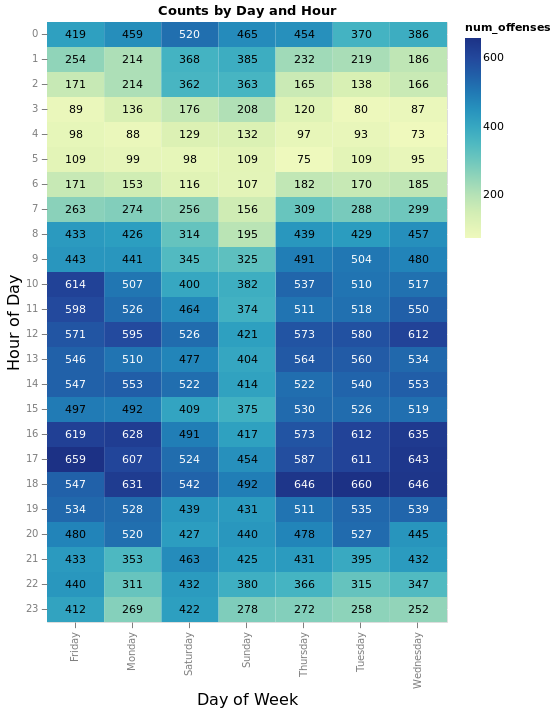

In [32]:
heatmap_base = (
    data
    .properties(title="Counts by Day and Hour", height=600, width=400)
    .transform_aggregate(
        num_offenses="count()",
        groupby=["HOUR", "DAY_OF_WEEK"]
    )
    .encode(
        x=alt.X("DAY_OF_WEEK:O", title="Day of Week"),
        y=alt.Y("HOUR:O", title="Hour of Day"),
        tooltip=[alt.Tooltip("DAY_OF_WEEK", title="Day of Week"),
                alt.Tooltip("HOUR", title="Hour of Day"),
                alt.Tooltip("num_offenses:Q", title="Number of Offenses")],
        color="num_offenses:Q"
))

heatmap = heatmap_base.mark_rect()
heatmap_text = heatmap_base.mark_text(baseline='middle').encode(
    text='num_offenses:Q',
    color=alt.condition(
        alt.datum.num_offenses < 500,
        alt.value('black'),
        alt.value('white')
    )
)
day_hour_counts = heatmap + heatmap_text
day_hour_counts